In [2]:
%matplotlib inline 
import numpy as np 
import os, pickle, time
import pyemma as py 
import mdtraj as md 
import nglview as nv 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [12]:
import tensorflow as tf
import tensorflow.keras.backend as K
#import tensorflow.compat.v1.keras.backend as K

#config = tf.compat.v1.ConfigProto()
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
 
# Create a session with the above options specified.
K.tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))

AttributeError: module 'tensorflow.keras.backend' has no attribute 'tensorflow'

In [10]:
import tensorflow.compat

In [ ]:
import sys
sys.path.append('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/LSS_components')
from hde import hde, MolGen, Propagator

## generate trajectory

In [1]:
#trajs_files = ['/home/kengyangyao/data/dataset/1_Trpcage_2JOF/0_simulation/200us_DEShaw/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-%03d.dcd' % item
#              for item in range(50)]
#trajs_all = [md.load(item, top='/home/kengyangyao/data/dataset/1_Trpcage_2JOF/0_simulation/200us_DEShaw/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein.pdb')
#             for item in trajs_files]
traj = md.load('/Users/aawad/OneDrive/Documents/LSS_all_files/TRPcage/temp_traj.h5')

NameError: name 'md' is not defined

In [7]:
#traj = md.join(trajs_all)

In [6]:
def get_timescales(data, lag):
    if type(data) is list:
        temp_pair = (np.concatenate([item_traj[:-lag:lag] for item_traj in data]),
                     np.concatenate([item_traj[lag::lag] for item_traj in data]))
    else:
        temp_pair = (data[:-lag:lag], data[lag::lag])
    return -lag / np.log(np.corrcoef(temp_pair[0], temp_pair[1])[0][1])

## Prepare trajectory

In [7]:
# trj_dir = "/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"
# trj_file = os.path.join(trj_dir, "trp-cage_rmsdmin.dcd")
# pdb_file = os.path.join(trj_dir, "2JOF-0-protein.pdb")

In [8]:
# traj = md.load(trj_file, top=pdb_file)

In [9]:
traj.superpose(traj[0])

NameError: name 'traj' is not defined

In [10]:
alpha = traj.top.select_atom_indices('alpha')
traj_ca = traj.atom_slice(alpha)

NameError: name 'traj' is not defined

In [11]:
traj_ca.superpose(traj_ca[0])

NameError: name 'traj_ca' is not defined

In [24]:
xyz = traj_ca.xyz.reshape(-1, len(alpha)*3)

In [25]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [26]:
y_train = scaler.fit_transform(xyz)

## Load SRV for reference

In [12]:
with open('lss_files/hde_model_078.pkl', 'rb') as f:
    srv = pickle.load(f)

Using TensorFlow backend.


C:\Users\aawad\anaconda3\envs\PyGPU\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
srv._encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_313 (InputLayer)       (None, 257)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 100)               25800     
_________________________________________________________________
batch_normalization_79 (Batc (None, 100)               400       
_________________________________________________________________
dense_236 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_237 (Dense)            (None, 7)                 707       
_________________________________________________________________
gaussian_noise_79 (GaussianN (None, 7)                 0         
Total params: 37,007
Trainable params: 36,807
Non-trainable params: 200
_________________________________________________________________


##  Load SRV coordinates

In [3]:
Z = np.load('lss_files/hde_coords.npy')
print(Z)

[[-2.2220640e+00 -2.7461052e-03 -4.8637390e-05 ...  3.2797718e-01
   3.4070015e-03  1.2670994e-02]
 [-2.2201221e+00  6.9851875e-03  9.7711086e-03 ...  2.9644966e-01
   2.1250248e-03  2.9906034e-02]
 [-2.2246542e+00 -4.0698051e-03 -3.5983324e-03 ...  3.3520985e-01
  -8.0108643e-04  8.6567402e-03]
 ...
 [-2.1939452e+00  2.8890073e-02  4.3350101e-02 ...  1.6639423e-01
   9.8657608e-04  1.0686326e-01]
 [-2.1928322e+00  3.8845360e-02  6.1335564e-02 ...  1.4590120e-01
  -1.3196945e-02  9.5866442e-02]
 [-2.1893070e+00  4.3324411e-02  2.8441429e-02 ...  1.0629940e-01
   6.5448284e-03  1.1007333e-01]]


In [4]:
srv_scaler = MinMaxScaler(feature_range=(-1,1))

In [6]:
x_train = srv_scaler.fit_transform(Z[:,[0,2,3]])
print(x_train)

[[-0.9915775  -0.74601257 -0.50507164]
 [-0.9902868  -0.7438494  -0.5022325 ]
 [-0.9932991  -0.7467945  -0.50529045]
 ...
 [-0.97288823 -0.73645234 -0.4841858 ]
 [-0.9721484  -0.73249036 -0.48576754]
 [-0.96980536 -0.73973656 -0.4879125 ]]


# Fit Generator

In [38]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=20000,
    noise_dim=100,
    n_epochs=100000,
    hidden_layer_depth=3,
    hidden_size=200,
    n_discriminator=5
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 60)                12060     
Total params: 113,260
Trainable params: 113,260
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               12800     
_________________________________________________________________
dens

In [39]:
#molgen.fit(x_train, y_train)

In [40]:
#molgen.generator.save('generator.h5')

In [41]:
#molgen.discriminator.save('discriminator.h5')

In [42]:
# with open('trp_cage_molgen.pkl', 'wb') as f:
#     pickle.dump(molgen, f)

In [43]:
from hde.molgen import swish

In [44]:
molgen.generator = tf.keras.models.load_model('lss_files/generator_new_test.h5', custom_objects={'swish': swish})
molgen.discriminator = tf.keras.models.load_model('lss_files/discriminator_new_test.h5', custom_objects={'swish': swish})

## Propagator

In [45]:
n_mix = 25
lag = 100

In [46]:
prop_scaler = MinMaxScaler(feature_range=(0,1))

In [47]:
traj_prop = x_train

In [48]:
traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [49]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)
]

In [50]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag, 
    batch_size=200000, 
    learning_rate=0.0005, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [51]:
from hde.propagator import get_mixture_loss_func

In [52]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=0.0001))

Best so far: 
- -11.4 (hidden_size = 100, n_mix = 10)
- -11.65 (hidden_size = 20, n_mix = 20, activation = relu)
- -12.12 (hidden_size = 100, n_mix = 25, activation = relu)

In [53]:
#prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=0.001))
#prop.fit([traj_prop_scaled, traj_prop_scaled[::-1]])

In [54]:
# with open('trp_prop_weights.pkl', 'wb') as f:
#     pickle.dump(prop.model.get_weights(), f)

In [55]:
with open('lss_files/trp_prop_weights_1.pkl', 'rb') as f:
    prop.model.set_weights(pickle.load(f))

## Generate multiple trajectories

In [56]:
# synth_trajs = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), 10440).reshape(10440, -1) for _ in range(100)]
# np.save('/home/kengyangyao/data/LSS_paper_files/synth_trajs', synth_trajs)
synth_trajs = np.load('/Users/aawad/OneDrive/Documents/LSS_all_files/LSS_paper_files/synth_trajs.npy')

In [57]:
x_prop = prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), 10000)
x_prop = x_prop.reshape(10000, -1)

In [58]:
-lag / np.log(np.corrcoef(traj_prop[:-lag:lag, 0], traj_prop[lag::lag, 0])[0][1]) * 0.2

2934.895660396802

In [59]:
def get_timescales_blocking(trajs, lag_time, num_blocks):
    result = []
    temp_size = trajs.shape[0] // num_blocks
    for item in range(num_blocks):
        temp_traj = trajs[item * temp_size: (item+1) * temp_size]
        if temp_traj.ndim == 1:
            temp_pair = (temp_traj[:-lag_time:lag_time], temp_traj[lag_time::lag_time])
        elif temp_traj.ndim == 2:
            temp_pair = (np.concatenate([item_traj[:-lag_time:lag_time] for item_traj in temp_traj]),
                         np.concatenate([item_traj[lag_time::lag_time] for item_traj in temp_traj]))
        result.append(-lag_time / np.log(np.corrcoef(temp_pair[0], temp_pair[1])[0,1]))
    return np.array(result)

for item in range(3):
    timescales_md = get_timescales_blocking(traj_prop_scaled[:, item], 100, 5)
    print(0.2 * timescales_md.mean(), 0.2 * timescales_md.std())
for item in range(3):
    timescales_lss = get_timescales_blocking(synth_trajs[:,:, item], 1, 5)
    print(100 * 0.2 * timescales_lss.mean(), 100 * 0.2 * timescales_lss.std())

3002.405579029793 607.5120447310386
538.8966382769831 370.12167868813134
451.9073164106637 118.54539551432006
2889.687930025424 196.90808446220674
427.0337800740476 37.08323082527312
415.18149996644405 13.312683360277077


In [62]:
np.array(synth_timescales).mean(axis=0), np.array(synth_timescales).std(axis=0)

(array([14202.78045615,  2064.40350471,  2062.85361228]),
 array([2764.067281  ,  786.78146685,  295.09836994]))

In [63]:
synth_timescales = []
for st in synth_trajs:
    
    tss = []
    for i in range(st.shape[1]):
        tc = np.corrcoef(st[:-1:1,i], st[1::1,i])[0,1]
        ts = -lag/np.log(tc)
        tss.append(ts)
    synth_timescales.append(tss)

In [64]:
synth_timescales = np.array(synth_timescales)

In [65]:
ref_timescales = [] 
for i in range(3):
    tc = np.corrcoef(traj_prop_scaled[:-lag:lag,i], traj_prop_scaled[lag::lag,i])[0,1]
    ts = -lag/np.log(tc)
    ref_timescales.append(ts)

ref_timescales = np.array(ref_timescales)

In [66]:
sort_idx = np.argsort(np.sqrt(np.sum((synth_timescales - ref_timescales)**2, axis=1)))

In [67]:
top_synth_trajs = [synth_trajs[i] for i in sort_idx[:10]]  # choose optimal 10 synthetic trajectories

In [68]:
np.mean(synth_timescales[sort_idx[:10]], axis=0)

array([14632.04196742,  2573.17300885,  2073.99267346])

In [69]:
np.std(synth_timescales[sort_idx[:10]], axis=0)

array([591.09821639, 418.25162743, 244.3177718 ])

In [70]:
ref_timescales

array([14674.47839851,  2844.20018763,  2314.54976916])

In [71]:
counts_transitions = np.array([14, 9, 11, 11, 12, 10, 11, 10, 8, 11])
print(counts_transitions.mean(), counts_transitions.std())

10.7 1.5524174696260022


In [72]:
#fig, ax = plt.subplots()
#ax.plot(top_synth_trajs[9][:, 0])
#ax.plot(traj_prop_scaled[:, 0])
#fig.set_size_inches((15, 5))

## Free energy comparison

In [111]:
best_traj = top_synth_trajs[0]

In [112]:
Ff_s, xf_s = np.histogram(np.concatenate(top_synth_trajs)[:,0], bins=100)
Ff_r, xf_r = np.histogram(traj_prop_scaled[:,0], bins=100)

In [113]:
x_ticks = np.arange(0, 1.01, 0.01)

In [114]:
def uncertaity_with_blocking(data_to_use, num=5):
    fes_list = []
    data_length = data_to_use.shape[0]
    for _1 in range(num):
        itersample = data_to_use[data_length // num * _1: data_length // num * (_1+1)]
        fes_count = np.histogram(itersample, bins=x_ticks, density=False)[0] + 1
        fes_count = fes_count / fes_count.sum()
        fes_list.append(-np.log(fes_count))
    fes_list = np.array(fes_list)
    confidence_interval = np.array([fes_list.mean(axis=0) - 1.96 * fes_list.std(axis=0),
                           fes_list.mean(axis=0) + 1.96 * fes_list.std(axis=0)]).T
    return fes_list, confidence_interval

fes_list_md, confidence_interval_md = uncertaity_with_blocking(traj_prop_scaled[:,0])
fes_list_lss, confidence_interval_lss = uncertaity_with_blocking(np.concatenate(synth_trajs)[:, 0], num=5)

In [115]:
# bootstrap for uncertainty estimation
def bootstrap_for_uncertainty_estimate(data_to_use, num=100):
    fes_list = []
    for _ in range(num):
        itersample = np.random.choice(data_to_use, size=data_to_use.shape, replace=True)
        fes_list.append(-np.log(np.histogram(itersample, bins=x_ticks, density=True)[0]))
    fes_list = np.array(fes_list)
    high_per, low_per = 1 - 0.025, 0.025
    confidence_interval = []
    for item in fes_list.T:
        item.sort()
        nn = len(item)
        low_val, high_val = item[int(np.floor(nn * low_per))], item[int(np.floor(nn * high_per))]
        confidence_interval.append([low_val, high_val])
    confidence_interval = np.array(confidence_interval)
    return fes_list, confidence_interval

# fes_list_md, confidence_interval_md = bootstrap_for_uncertainty_estimate(traj_prop_scaled[:,0])
# fes_list_lss, confidence_interval_lss = bootstrap_for_uncertainty_estimate(np.concatenate(synth_trajs)[:, 0])

In [116]:
np.mean((confidence_interval_md[:, 1] - confidence_interval_md[:, 0]) 
        / (confidence_interval_lss[:, 1] - confidence_interval_lss[:, 0]))

9.575429891648527

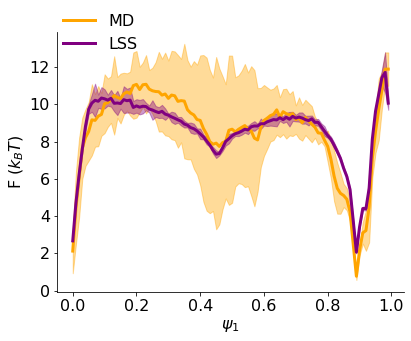

In [117]:
fes_offset = fes_list_md.mean() - fes_list_lss.mean()
fes_list_lss = fes_list_lss + fes_offset
confidence_interval_lss = confidence_interval_lss + fes_offset
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(6, 5))
plt.plot(x_ticks[:-1], np.mean(fes_list_md, axis=0), linewidth=3, color='orange')
plt.plot(x_ticks[:-1], np.mean(fes_list_lss, axis=0), linewidth=3, color='purple')
plt.fill_between(x_ticks[:-1], confidence_interval_md[:, 0], confidence_interval_md[:, 1], alpha=0.4, color='orange')
plt.fill_between(x_ticks[:-1], confidence_interval_lss[:, 0], confidence_interval_lss[:, 1], alpha=0.4, color='purple')
plt.xlabel(r'$\psi_1$')
plt.ylabel('F ($k_BT$)')
i = 0
for spine in plt.gca().spines.values():
    if (i+1) % 2 == 0:
        spine.set_visible(False)
    i += 1
    
plt.legend(['MD', 'LSS'], frameon=False, loc=(0, 0.9))

plt.tight_layout()    
plt.savefig('fes_comparison.png', dpi=300)

In [159]:
np.sqrt(np.mean((-np.log(Ff_r) - (-np.log(Ff_s)-1.2))**2))

0.8660960162483972

In [123]:
def gen_mol_traj(x_scaled):
    molgen.is_fitted = True
    x_unscaled = prop_scaler.inverse_transform(x_scaled)
    synth = scaler.inverse_transform(molgen.transform(x_unscaled)).reshape(-1, 20, 3)
    gen_traj = traj_ca.slice(range(synth.shape[0]))
    
    for i in range(len(gen_traj)):
        gen_traj.xyz[i] = synth[i] 

    gen_traj.superpose(gen_traj[0])
    
    return gen_traj

In [124]:
def get_closest_frames(val, idx, traj, n=10):
    matches = np.argsort(np.abs(traj[:,idx] - val))
    return matches[:n]

In [158]:
def get_RMSD_within_SRV_range(traj, srv_val, val_lo, val_hi):
    idx = (srv_val > val_lo) & (srv_val < val_hi)
    frames = traj[idx]
    result = np.sqrt(frames.xyz.var(axis=0).sum(axis=1).mean())
    return result

print(get_RMSD_within_SRV_range(traj_ca, traj_prop_scaled[:, 0], 0.4, 0.5))
print(get_RMSD_within_SRV_range(md.join(synth_all_trajs),
                                np.concatenate(synth_trajs)[:, 0], 0.4, 0.5))

0.13786413
0.20079914


Select structures closest to different CV values, then generate ensembles.

First pose

In [160]:
synth_idx = get_closest_frames(0., 0, best_traj)
ref_idx = get_closest_frames(0, 0, traj_prop_scaled)

In [161]:
synth_mol_1 = gen_mol_traj(best_traj[synth_idx])
ref_mol_1 = traj_ca[ref_idx]

In [162]:
np.mean(np.concatenate([md.rmsd(synth_mol_1, ref_mol_1[i]) for i in range(len(ref_mol_1))]))*10 # Angstrom

3.0402976274490356

In [163]:
np.mean(md.rmsd(synth_mol_1, ref_mol_1[6]))*10 # Angstrom. Central structure. 

2.988320291042328

In [166]:
ref_2jof = md.load('/Users/aawad/OneDrive/Documents/LSS_all_files/2jof.pdb')
ref_2jof = ref_2jof.atom_slice(ref_2jof.top.select_atom_indices('alpha'))
np.mean(md.rmsd(synth_mol_1, ref_2jof))

0.2779588

In [167]:
synth_mol_1.save_pdb('synth_mol_1.pdb')
ref_mol_1.save_pdb('ref_mol_1.pdb')

Third pose

In [168]:
synth_idx = get_closest_frames(0.45, 0, best_traj)
ref_idx = get_closest_frames(0.45, 0, traj_prop_scaled)

In [169]:
synth_mol_3 = gen_mol_traj(best_traj[synth_idx])
ref_mol_3 = traj_ca[ref_idx]

In [170]:
synth_mol_3.save_pdb('synth_mol_3.pdb')
ref_mol_3.save_pdb('ref_mol_3.pdb')

In [171]:
np.mean(np.concatenate([md.rmsd(synth_mol_3, ref_mol_3[i]) for i in range(len(ref_mol_3))]))*10 # Angstrom

3.52274090051651

## TICA

In [172]:
import pyemma as py

In [173]:
featurizer = py.coordinates.featurizer(traj_ca.topology)
featurizer.add_distances_ca(periodic=False)

In [174]:
feature_source = py.coordinates.source(traj_ca.xyz, features=featurizer)

In [175]:
feature_data = feature_source.get_output()[0]

In [176]:
tica = py.coordinates.tica(data=feature_data, lag=100, dim=3, kinetic_map=True)

In [177]:
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

In [178]:
synth_all_trajs = [gen_mol_traj(x) for x in synth_trajs]

In [179]:
synth_full = [x.xyz for x in synth_all_trajs]

In [180]:
py.config.show_progress_bars = False

In [181]:
synth_feat_source = py.coordinates.source(synth_full, features=featurizer)

In [182]:
synth_feature_data = synth_feat_source.get_output()

In [183]:
synth_tica_list = tica.transform(synth_feature_data)
synth_tica_output = np.concatenate(synth_tica_list)

In [184]:
np.array([get_timescales([item[:, _1] for item in synth_tica_list], 1) * 100 for _1 in range(3)]) * 0.2

array([167.92471418,  23.11895802,   8.74567856])

In [185]:
tica.timescales[:5] * 0.2

array([184.35500544,  62.90569517,  36.84374396,  25.86800399,
        22.96492427])

In [186]:
tica_timescales_blocks_md = np.array([get_timescales_blocking(tica_concatenated[:, ii], lag, 5) for ii in range(3)])
tica_timescales_blocks_lss = np.array([get_timescales_blocking(np.array(synth_tica_list)[:,:,ii], 1, 5) for ii in range(3)])
print(tica_timescales_blocks_md.mean(axis=1) * 0.2, tica_timescales_blocks_md.std(axis=1) * 0.2, 
      tica_timescales_blocks_lss.mean(axis=1) * 20, tica_timescales_blocks_lss.std(axis=1) * 20)

[175.08595319  60.18126949  34.8251868 ] [72.87916135 15.97994496 10.92331816] [167.75659897  23.12129644   8.73630508] [13.60061328  0.61690608  0.25007722]


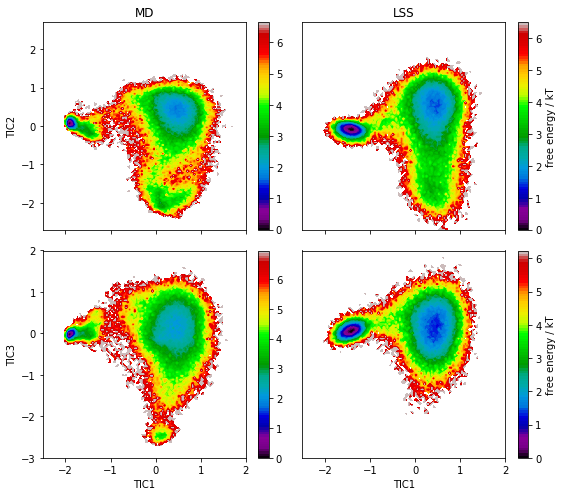

In [187]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7), sharex=True)

y_axes = [(-2.7, 2.7), (-3, 2)]
for i in range(2):
    _, _, misc = py.plots.plot_free_energy(tica_concatenated[::10,0], tica_concatenated[::10,i+1], ax=ax[i,0], cbar_label=None, legacy=False)
    misc['cbar'].set_ticks(np.arange(0, 11))
    _, _, misc = py.plots.plot_free_energy(synth_tica_output[::10,0], synth_tica_output[::10,i+1], ax=ax[i,1], legacy=False)    
    misc['cbar'].set_ticks(np.arange(0, 11))
    ax[i,0].set_ylim(y_axes[i])
    ax[i,1].set_ylim(y_axes[i])
    ax[i,1].set_yticks([])
    ax[i,0].set_xlim([-2.5, 2])
    ax[i,1].set_xlim([-2.5, 2])

ax[0,0].set_title('MD')
ax[0,1].set_title('LSS')
ax[0,0].set_ylabel('TIC2')
ax[1,0].set_xlabel('TIC1')
ax[1,0].set_ylabel('TIC3')
ax[1,1].set_xlabel('TIC1')
plt.tight_layout()
plt.savefig('tica_trpcage.pdf', dpi=300)

In [188]:
# for i, x_dim in enumerate(x_prop.T):
#     plt.hist(2*(x_dim-0.5), bins=100);
#     plt.hist(traj_prop[::100, i], bins=100, alpha=0.5);
#     plt.show()

## Compare timescales

In [189]:
for i in range(3):
    tc = np.corrcoef(traj_prop_scaled[:-lag:lag,i], traj_prop_scaled[lag::lag,i])[0,1]
    ts = -lag/np.log(tc)
    print(f'Reference Timescale {i}: {ts}')
    
    tc = np.corrcoef(x_prop[:-1:1,i], x_prop[1::1,i])[0,1]
    ts = -lag/np.log(tc)

    print(f'Synthetic Timescale {i}: {ts}\n')

Reference Timescale 0: 14674.47839850653
Synthetic Timescale 0: 9220.353057189734

Reference Timescale 1: 2844.2001876303216
Synthetic Timescale 1: 1208.4813960564131

Reference Timescale 2: 2314.549769157633
Synthetic Timescale 2: 1839.0478473137691



In [190]:
srv.timescales_

array([15202.95527403,  5530.1103633 ,  2760.02392811,  2282.64666781,
        1392.44260236,  1167.53880509,   845.65863691])

In [191]:
x_prop_unscaled = prop_scaler.inverse_transform(x_prop)

## Sample molecules

In [192]:
molgen.is_fitted = True

In [193]:
synth = scaler.inverse_transform(molgen.transform(x_prop_unscaled)).reshape(-1, 20, 3)

Using synthetic data, override existing mdtraj struct

In [194]:
gen_traj = traj_ca.slice(range(synth.shape[0]))

In [195]:
for i in range(len(gen_traj)):
    gen_traj.xyz[i] = synth[i] 

In [196]:
gen_traj.superpose(gen_traj[0])

<mdtraj.Trajectory with 10000 frames, 20 atoms, 20 residues, and unitcells at 0x180d4c624c8>

In [197]:
nv.show_mdtraj(gen_traj)

NGLWidget(max_frame=9999)

Save trajectory

In [198]:
gen_traj.save_pdb('synthetic_trajectory.pdb')

In [199]:
nv.show_file('synthetic_trajectory.pdb')

NGLWidget()

In [200]:
generated_complete_traj = gen_mol_traj(best_traj)

In [201]:
nv.show_mdtraj(generated_complete_traj)

NGLWidget(max_frame=10439)

## more analysis

In [202]:
real_rg = md.compute_rg(traj_ca)
synth_rg = np.concatenate([md.compute_rg(item) for item in synth_all_trajs])

In [203]:
# _ = plt.hist(real_rg, normed=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k', bins=20)
# _ = plt.hist(synth_rg, normed=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k', bins=20)

In [204]:
print(real_rg.mean(), real_rg.std(), synth_rg.mean(), synth_rg.std())

0.865238873524714 0.16274522113673479 0.8697210308354807 0.13231088563603796


In [205]:
from scipy.stats import ks_2samp
ks_2samp(real_rg, synth_rg)

Ks_2sampResult(statistic=0.20685249042145595, pvalue=0.0)

C:\Users\aawad\anaconda3\envs\PyGPU\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aawad\anaconda3\envs\PyGPU\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


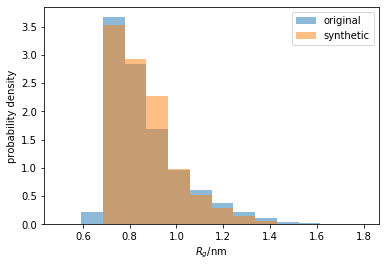

In [206]:
fig, ax = plt.subplots()
hist_bins = np.linspace(0.5, 1.8, 15)
_ = ax.hist(real_rg, alpha=0.5, bins=hist_bins, normed=True, label='original')
_ = ax.hist((synth_rg), alpha=0.5, bins=hist_bins, normed=True, label='synthetic')
ax.legend()
ax.set_xlabel('$R_g$/nm')
ax.set_ylabel('probability density')
fig.savefig('rg_hist.pdf', bbox_inches = 'tight', dpi=300)

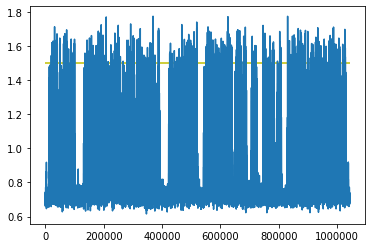

In [207]:
data_to_plot = real_rg
plt.plot(data_to_plot)
plt.hlines(0.7, 0, data_to_plot.shape[0], color='r')
plt.hlines(1.5, 0, data_to_plot.shape[0], color='y')

In [208]:
# compute mean first passage time
def get_state(rg):
    result_states = rg
    result_states[np.where(rg < 0.7)] = 0
    result_states[np.all([0.7 <= real_rg, real_rg < 1.5], axis=0)] = 1
    result_states[np.where(rg >= 1.5)] = 2
    return result_states
    
real_states = get_state(real_rg)

In [209]:
def get_mfpt_list(states_list, current_state):
    mfpt = []
    events = []
    current_idx = 0
    for idx, item in enumerate(states_list):
        if abs(item - current_state) == 2:
            mfpt.append(idx - current_idx)
            events.append([current_idx, idx])
            current_state = item
            current_idx = idx
    return np.array(mfpt), np.array(events)

real_mfpt, events = get_mfpt_list(real_states, 0)

In [206]:
############################

In [210]:
_, dihedrals = md.compute_psi(traj)

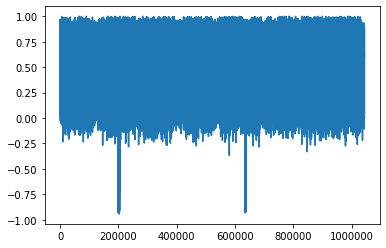

In [211]:
plt.plot(np.sin(dihedrals[:, 17]))